In [ ]:
import serial
import serial.tools.list_ports as sertools

import matplotlib.pyplot as plt

from IPython.display import clear_output

from scipy.fft import fft, fftfreq
from scipy.signal import blackman
import numpy as np

plt.rcParams["figure.figsize"] = (15, 5) #(20,10)

devices = sertools.comports()
device = 0

for p in devices:
    print(p.device + " (" + str(p.manufacturer) + " - " + str(p.product) + ")")

print("Connecting to " + devices[device].name)

with serial.Serial(devices[device].name, 115200, timeout=5) as ser:
    while True:
        l = ser.readline().decode('ascii')

        values = [float(i) for i in l.strip().removeprefix('[').removesuffix(']').split(',')]

        N = len(yf)

        x = np.array(values)
        yf = fft(x * blackman(N))

        T = 1.0 / 1024
        xf = fftfreq(N, T)[:N//2]
        
        plt.plot(xf, values)
        #plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
        #plt.ylim((0, 1024))
        #plt.xticks(np.arange(min(xf), max(xf), 20.0))
        plt.xlabel('')
        plt.ylabel('')
        plt.draw()
        plt.pause(0.0001)

In [ ]:
from math import floor
from scipy.fftpack import fftshift
import serial
import serial.tools.list_ports as sertools

import matplotlib.pyplot as plt

from IPython.display import clear_output

from scipy.fft import fft, fftfreq
from scipy.signal import butter, lfilter, blackman
import numpy as np


plt.rcParams["figure.figsize"] = (15, 5) #(20,10)

devices = sertools.comports()
device = 0


def butter_bandpass_filter(data, lowCut, highCut, fs, order = 5):
    nyq = 0.5 * fs
    low = lowCut / nyq
    high = highCut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = lfilter(b, a, data)
    return y


def plot(x, y):
    plt.plot(x, y)
    plt.xlabel('')
    plt.ylabel('')
    plt.draw()
    plt.pause(0.0001)
    #plt.ylim(0, 1024)


def main():
    for p in devices:
        print(p.device + " (" + str(p.manufacturer) + " - " + str(p.product) + ")")

    print("Connecting to " + devices[device].name)

    with serial.Serial(devices[device].name, 115200, timeout=5) as ser:
        while True:
            l = ser.readline().decode('ascii')
            values = [float(i) for i in l.strip().removeprefix('[').removesuffix(']').split(',')]

            # Sample rate and cutoff frequency
            t = 2
            fs = 512
            lowCut = 5
            highCut = 500

            x = np.arange(0, fs, 1/t)
            #y = butter_bandpass_filter(values, lowCut, highCut, fs, 9)
            y = fft(values)
            #y = fft(values * blackman(len(values)))
            y = [np.sqrt(val.imag*val.imag + val.real*val.real) for val in y]
            y = fftshift(y)
            plot(x, y)
            #plot(x[:floor(len(x)/2)], y[:floor(len(y)/2)])
            #plot(x, values)

main()

## Plot the raw data received by the device and locally calculate the FFT

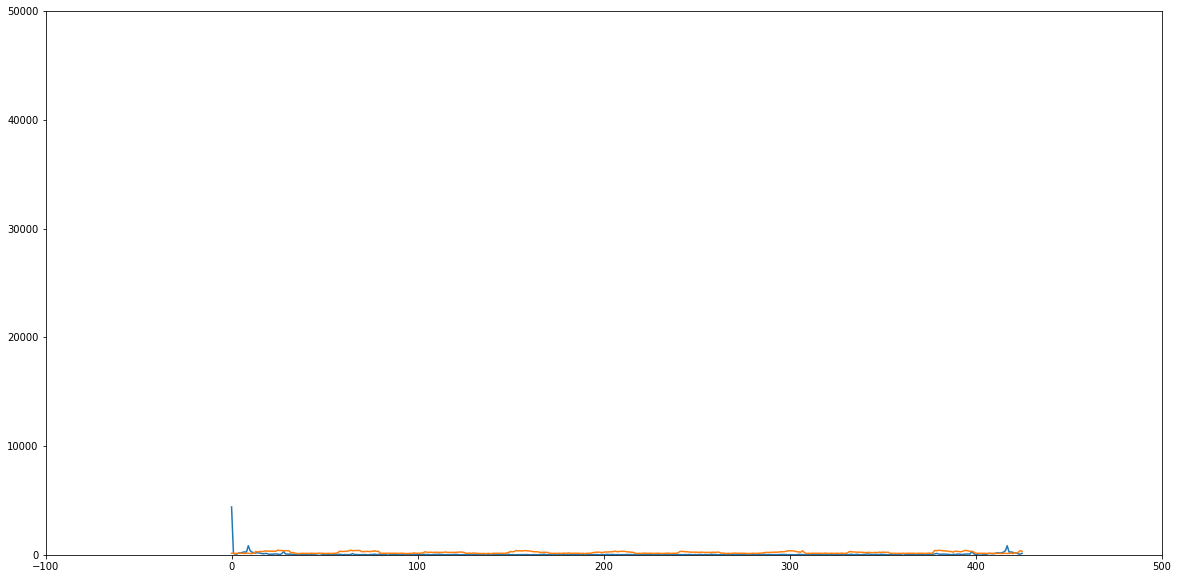

Maximum Signal strength: 22.0


SerialException: ClearCommError failed (PermissionError(13, 'Das Gerät erkennt den Befehl nicht.', None, 22))

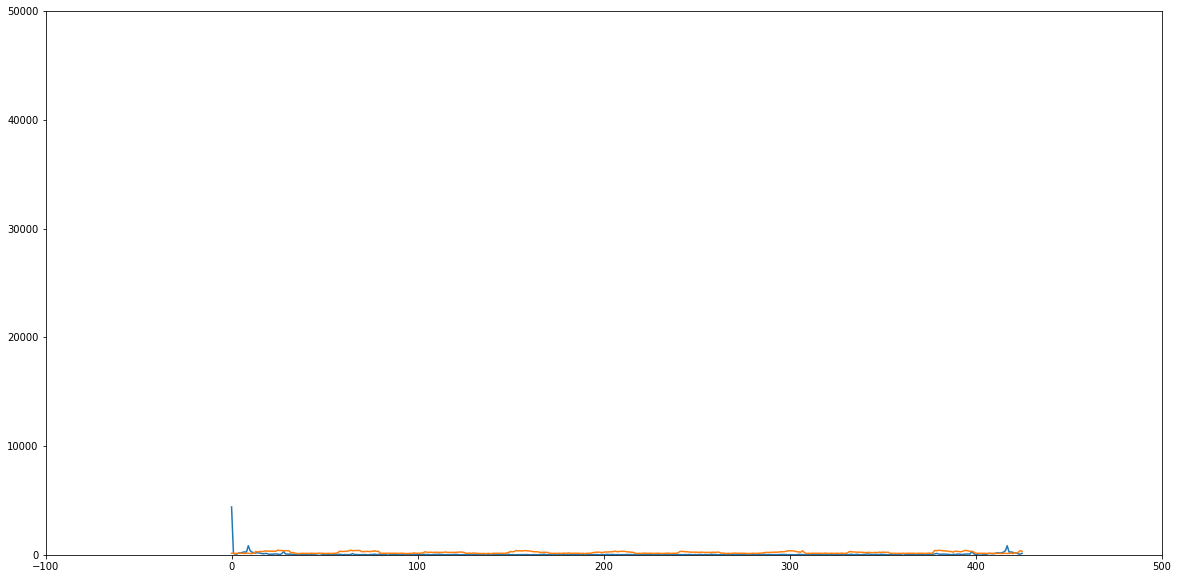

In [4]:
%matplotlib inline 
# widget/inline

# https://github.com/microsoft/vscode-jupyter/wiki/Using-%25matplotlib-widget-instead-of-%25matplotlib-notebook,tk,etc
# https://matplotlib.org/stable/users/explain/interactive.html?highlight=jupyter#ipython-pylab
# pip install ipympl

import numpy as np
from math import sqrt
from scipy.fftpack import fftshift
import serial
import serial.tools.list_ports as sertools

import matplotlib.pyplot as plt

from scipy.fft import fft
from scipy.signal import find_peaks, blackman

from IPython.display import display, clear_output

devices = sertools.comports()
device = 1

plt.ion()
fig, ax = plt.subplots(figsize=(20, 10))

def plot(x, y, y_2):
    ax.clear()
    #if len(ax.lines) > 0:
    #    ax.lines[0].set_ydata(y)
    #else:
    ax.set_ylim(0, 100000)
    ax.plot(range(0, len(y)), y)
    ax.plot(range(0, len(y_2)), y_2)
    clear_output(wait=True)
    display(fig)
    
    #fig.canvas.draw()
    plt.pause(0.1)


def main():
    for p in devices:
        print(p.device + " (" + str(p.manufacturer) + " - " + str(p.product) + ")")

    print("Connecting to " + devices[device].name)

    with serial.Serial(devices[device].name, 115200, timeout=5) as ser:
        while True:
            # Gather data
            l = ser.readline().decode('ascii')

            if not l.startswith('['):
                print("Serial: " + l)
                continue

            values = [float(i) for i in l.strip().removeprefix('[').removesuffix(']').split(',')]
            #values = values * blackman(len(values)) # Apply Blackman Window Filter

            # Calculate FFT
            y = np.abs(fft(values))
            #y = [val.real for val in y][:int(len(y)/2)]
            #y = [sqrt(val.imag*val.imag + val.real*val.real) for val in y][:int(len(y)/2)]
            #y = fftshift(y)

            # Find Peaks
            peaks, a = find_peaks(y, 10000)

            # Plot
            ax.clear()
            ax.set_ylim(0, 50000) #  ax.set_ylim(0, 100000)

            ax.plot(range(0, len(y)), y)
            ax.plot(range(0, len(values)), [v*20 for v in values])
            ax.scatter(peaks, [y[int(p)] for p in peaks])

            ticks = list(plt.xticks()[0])
            ticks.extend(peaks)
            ax.set_xticks(ticks)

            clear_output(wait=True)
            display(fig)
            print("Maximum Signal strength: " + str(max(values)))

main()

## Plot the individual channels of the IR-Receiver

In [ ]:
%matplotlib inline

import serial
import serial.tools.list_ports as sertools
import matplotlib.pyplot as plt

from IPython.display import display, clear_output

from matplotlib.animation import TimedAnimation

devices = sertools.comports()
device = 1
ser = None

fig, ax = plt.subplots()
bars = ax.bar([f"D{str(i)}" for i in range(1, 16+1)], [i for i in range(0, 16)])


def graph_init():
    #plt.ion()
    #ax.set_ylim(0, 5000)
    return bars


def graph_update(values):
    ax.cla()
    graph_init()
    ax.bar([f"D{str(i)}" for i in range(1, 16+1)], values, bottom=0)
    #plt.show()
    display(fig)
    clear_output(wait=True)

    #fig.canvas.draw()
    #fig.canvas.flush_events()


def main():
    global ser
    
    for p in devices:
        print(p.device + " (" + str(p.manufacturer) + " - " + str(p.product) + ")")

    print("Connecting to " + devices[device].name)
    
    graph_init()

    with serial.Serial(devices[device].name, 115200, timeout=5) as ser:
        display(fig.canvas)
        while True:
            try:
                l = ser.readline().decode('ascii')
                if not l.startswith('['):
                    print("[Serial] " + l)
                    continue

                graph_update([float(i) for i in l.strip().removeprefix('[').removesuffix(']').split(',')])
            except KeyboardInterrupt:
                print("KeyboardInterrupt")
                break

main()

## Plot single graph

In [ ]:
# pip install pyserial numpy scipy matplotlib

import numpy as np
from math import sqrt
import serial
import serial.tools.list_ports as sertools

import matplotlib.pyplot as plt
from scipy.signal import find_peaks

from IPython.display import display, clear_output

devices = sertools.comports()
device = 0

plt.ion()
fig, ax = plt.subplots(figsize=(20, 10))

def plot(x, y, y_2):
    ax.clear()
    ax.set_ylim(0, 100000)
    ax.plot(range(0, len(y)), y)
    ax.plot(range(0, len(y_2)), y_2)
    clear_output(wait=True)
    display(fig)
    plt.pause(0.1)


def main():
    for p in devices:
        print(p.device + " (" + str(p.manufacturer) + " - " + str(p.product) + ")")

    print("Connecting to " + devices[device].name)

    with serial.Serial(devices[device].name, 115200, timeout=5) as ser:
        while True:
            # Gather data
            l = ser.readline().decode('ascii')

            if not l.startswith('['):
                print("Serial: " + l)
                continue
            
            y = [float(i) for i in l.strip().removeprefix('[').removesuffix(']').split(',')]
            x = range(0, len(y))
            frequency = np.fft.fftfreq(len(y), 1/5000.0)

            # Find Peaks
            peaks, a = find_peaks(y, 25000)

            # Plot
            ax.clear()
            ax.set_ylim(0, 50000)

            ax.plot(x, y)
            ax.scatter(peaks, [y[int(p)] for p in peaks])

            ticks = list(plt.xticks()[0])
            ticks.extend(peaks)
            ax.set_xticks(ticks)

            clear_output(wait=True)
            display(fig)
            print("Maximum Signal strength: " + str(max(y)))
            print([(p, frequency[p]) for p in peaks])

main()

## Create a synthetic square wave and perform the DFT

[(10, 10), (30, 30), (50, 50), (70, 70), (90, 90), (110, 110), (130, 130), (150, 150), (170, 170), (342, 342), (362, 362), (382, 382), (402, 402), (422, 422), (442, 442), (462, 462), (482, 482), (502, 502)]


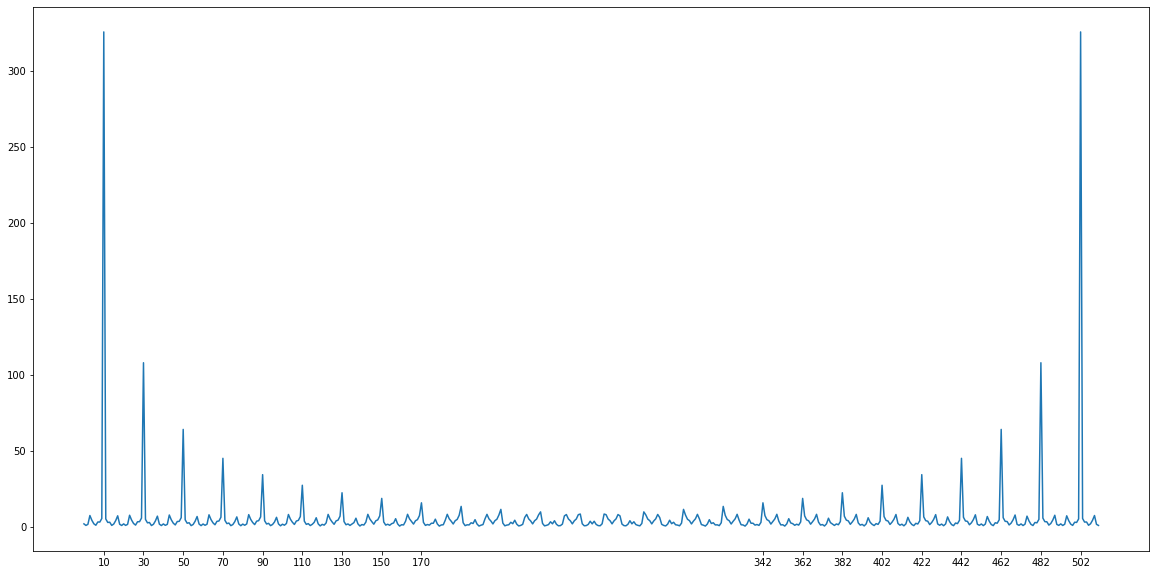

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.linalg import norm
from scipy.fft import fft, fftshift, fftfreq
from scipy.signal import square, find_peaks

SQUARE_FREQ = 975 # Hz
SAMPLE_FREQ = 50000 # Hz
SAMPLE_COUNT = 512

t = np.linspace(0, (1/SAMPLE_FREQ)*SAMPLE_COUNT, SAMPLE_COUNT, endpoint=False)
y = square(2 * np.pi * SQUARE_FREQ * t)

plt.figure(figsize=(20, 10), )
#plt.ylim(0, 25)

# DFT results
dftResult = np.abs(fft(y))

# FFT Freq
frequencyRange = range(0, len(dftResult))#
#frequencyRange = fftfreq(SAMPLE_COUNT, 1/SAMPLE_FREQ)

# Peaks in the spectrum
peaks, a = find_peaks(dftResult, 15)

plt.xticks([frequencyRange[x] for x in peaks])
plt.plot(frequencyRange, dftResult)

print([(x, frequencyRange[x]) for x in peaks])

$f_s = \frac{1}{512} = 0,001953125$

$0 \mathrm{Hz} - \frac{1}{512} \mathrm{Hz}$

Bins:
$n \cdot \frac{f_s}{N}$

Should be 975 Hz

# Diskrete Fourier Transformation
Berechne pro Frequency bin:

$\displaystyle X(k) = \sum_{n=0}^{N-1} x(n) \cdot e^{-\frac{2 \pi i}{N} k n}$

---

$\displaystyle \Re\left(X(k)\right) = \sum_{n=0}^{N-1} x(n) \cdot \cos{\left(\frac{-2 \pi k n}{N}\right)}$

$\displaystyle \Im\left(X(k)\right) = \sum_{n=0}^{N-1} x(n) \cdot \sin{\left(\frac{-2 \pi k n}{N}\right)}$

---

$\displaystyle P(f) = \frac{1}{f}$

$\displaystyle k = \frac{P(Gesamt)}{P(Ereigniss)}$

---

### Frequenz
Kehrwert der Schwingungsdauer $T$ oder $\lambda$: $\frac{1}{T}$

### Nyquist Frequenz
$\frac{f_s}{2}$

### Phase
Die Phase gibt die aktuelle Position im Ablauf eines periodischen Vorgangs an, also sprich die Phasenverschiebung von z.B. einer Sinus/Cosinus Funktion $\frac{\lambda}{2}$

### Amplitude
Betrag der maximalen Auslenkung der Funktion in y-Richtung (Positiv sowie Negativ) im Verhältniss zur Ruhelage.

---

### Hamming Window
$\displaystyle w(x) = 0.54 - 0.46 \cdot \cos{\left(\frac{2 \pi n}{N}\right)} from n=0 to N$

### Blackman Window
$\displaystyle w(x) = 0.42 - 0.5 \cdot \cos{\left(\frac{2 \pi n}{N}\right)} + 0.08 \cdot \cos{\left(\frac{4 \pi n}{N}\right)} \text{from } n=0 to N$

In [ ]:
from math import sin, cos, pi

k = 0.04 / 0.01

def fk_re(values, N, k):
    return sum([values[n] * cos((-2*pi*k*n) / N) for n in range(0, N)])

def fk_im(values, N, k):
    return sum([values[n] * sin((-2*pi*k*n) / N) for n in range(0, N)])

